In [1]:
import numpy as np
import pandas as pd

import pickle as pk
import scipy
import os
import shutil
import random

import cv2 
import matplotlib.pyplot as plt
import math
%matplotlib inline 

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import load_model

In [2]:
PATH = './DFN_dataset/'
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

# Set the path to your dataset directory
# dataset_path = './DFN_dataset/after_4_bis' #dataset from dogfacenet
# dataset_path = './DFN_dataset/organized_photos' #dataset from petfinger-dogs https://huggingface.co/datasets/drzraf/petfinder-dogs
# Set the paths for the training, test, and validation sets
# train_path = '../photos/organized_photos/train'
# test_path = '../photos/organized_photos/test'
# val_path = '../photos/organized_photos/val'

dataset_path = "../DFN_dataset/after_4_bis"
train_path = "../photos/dogfacenet/train"
test_path = "../photos/dogfacenet/test"
val_path = "../photos/dogfacenet/val"

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
# Set the ratio for splitting the dataset (e.g., 66% train, 13% test, 13% validation)
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2

# Create directories for training, test, and validation sets if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Iterate through each class folder in the dataset
for class_folder in os.listdir(dataset_path):
    # count number of files in folder
    num_of_files = len(os.listdir(os.path.join(dataset_path, class_folder)))
    if num_of_files < 5:
        continue
    class_path = os.path.join(dataset_path, class_folder)

    # Get a list of all files in the class folder
    files = os.listdir(class_path)

    # Shuffle the files randomly
    random.seed(42)
    random.shuffle(files)

    # Calculate the number of files for each set based on the ratios
    num_train = round(len(files) * train_ratio)
    num_test = round(len(files)* test_ratio)
    num_val = len(files) - num_train - num_test
    
    if num_train - num_test == 0 and num_test > 2 and num_val == 0:
        num_val = 1
        num_test = num_test - 1
    # Split the files into training, test, and validation sets
    train_files = files[:num_train]
    test_files = files[num_train:num_train + num_test]
    val_files = files[num_train + num_test:]

    # Move the files to their respective sets and create subdirectories
    for file in train_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_path, class_folder, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_path, class_folder, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for file in val_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(val_path, class_folder, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

NameError: name 'os' is not defined

In [3]:
# Initialize lists to store file paths and labels
train_file_paths = []
train_labels = []
val_file_paths = []
val_labels = []
test_file_paths = []
test_labels = []

# Iterate through each class folder in the training set
for class_folder in os.listdir(train_path):
    # get only folders that start with 1 2 or 3
    if class_folder.startswith(('1','2','3', '4')):
        class_path = os.path.join(train_path, class_folder)

    # Iterate through each file in the class folder
        for file in os.listdir(class_path):
            train_file_paths.append(os.path.join(class_path, file))
            train_labels.append(class_folder)


for class_folder in os.listdir(val_path):
    if class_folder.startswith(('1','2','3', '4')):
        class_path = os.path.join(val_path, class_folder)
    
        # Iterate through each file in the class folder
        for file in os.listdir(class_path):
            val_file_paths.append(os.path.join(class_path, file))
            val_labels.append(class_folder)

for class_folder in os.listdir(test_path):
    if class_folder.startswith(('1','2','3','4')):
        class_path = os.path.join(test_path, class_folder)
    
        # Iterate through each file in the class folder
        for file in os.listdir(class_path):
            test_file_paths.append(os.path.join(class_path, file))
            test_labels.append(class_folder)
        

# Create a DataFrame
train_df = pd.DataFrame({
    'File_Path': train_file_paths,
    'Label': train_labels
})

val_df = pd.DataFrame({
    'File_Path': val_file_paths,
    'Label': val_labels
})

test_df = pd.DataFrame({
    'File_Path': test_file_paths,
    'Label': test_labels
})


class_names = train_df['Label'].unique().tolist()

In [4]:
checkpoint_no = 'ckpt_5'
checkpoint_path = f'./output/checkpoints/'

model_name = 'model_5_resnet_dfn'
model_path = f'./output/models/'

if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)

In [5]:
input_shape = (224,224,3)
batch_size = 64
epochs = 300
steps_per_epoch = int(len(train_df)/batch_size)
validation_steps = int(len(val_df)/batch_size)
test_steps = int(len(test_df)/batch_size)

print("batch_size: ", batch_size)
print("epochs: ", epochs)
print("steps_per_epoch: ", steps_per_epoch)
print("validation_steps: ", validation_steps)
print("test_steps: ", test_steps)


batch_size:  64
epochs:  300
steps_per_epoch:  5
validation_steps:  1
test_steps:  1


In [6]:
# depending on the dataset, modify the number of output classes in the model in the block below
train_data_gen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
val_data_gen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
test_data_gen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
train_generator = train_data_gen.flow_from_dataframe(dataframe= train_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)
val_generator = val_data_gen.flow_from_dataframe(dataframe= val_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)
test_generator = test_data_gen.flow_from_dataframe(dataframe= test_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)

Found 320 validated image filenames belonging to 19 classes.
Found 83 validated image filenames belonging to 19 classes.
Found 79 validated image filenames belonging to 19 classes.


In [32]:
print("Creating the model...")
# initial model
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=input_shape))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3),activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3),activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3),activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(592, activation='softmax')) # number of classes after removing classes with less than 6 images
# model.summary()

# model with augmentation
# 
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(284, activation='sigmoid')) # number of classes after removing classes with less than 6 images
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])



Creating the model...


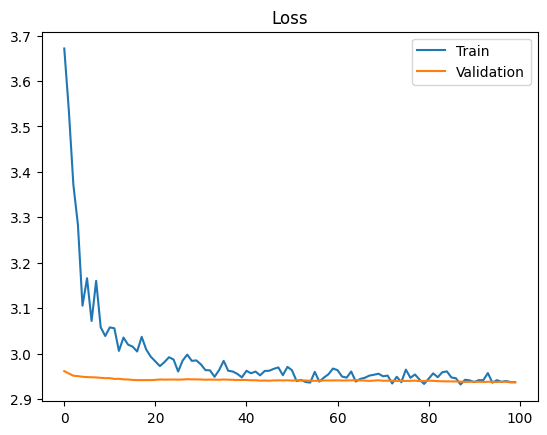

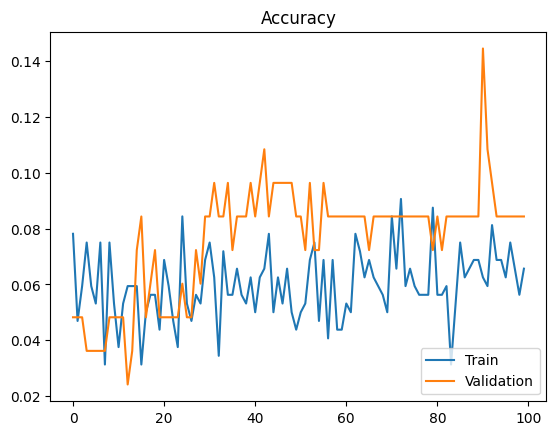

In [8]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

2/2 [==============================] - 1s 436ms/step - loss: 2.9366 - accuracy: 0.0759
The test loss is:  2.936570882797241
The best accuracy is:  7.594936341047287


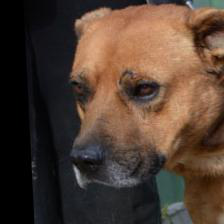

In [24]:
#Testing
img = tf.keras.preprocessing.image.load_img('../photos/dogfacenet/val/363/363.16.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img


In [25]:
# generate predictions for samples
predictions = model.predict(img_array)

# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

# get top 10 predictions
top_10_predictions = np.argsort(predictions[0])[:-11:-1]
print(top_10_predictions)


# top 10 predictions
for i in range(10):
    print(class_names[top_10_predictions[i]])

1/1 [==============================] - 0s 16ms/step
[18]
[18  3  5  4  0  9 12  8 16  7]
458
186
200
192
122
363
397
291
448
203


In [69]:
# save model and architecture to single file
model.save(model_path + model_name + '.h5')

In [36]:
# # Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
# checkpoint = ModelCheckpoint(filepath=model_path+model_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=15)
# callbacks = [checkpoint, reduce_lr]

In [37]:
# print("Training the model...")
# history = model.fit(train_generator,
#                               steps_per_epoch=steps_per_epoch,
#                               epochs=epochs,
#                               validation_data=val_generator,
#                               validation_steps=validation_steps,
#                               callbacks=callbacks)

Training the model...
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 6.1724 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 5.81240, saving model to ./output/models\model_4_newdataset.h5
15/15 [==============================] - 11s 593ms/step - loss: 6.1724 - accuracy: 0.0000e+00 - val_loss: 5.8124 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 2/300
15/15 [==============================] - ETA: 0s - loss: 5.7826 - accuracy: 0.0021
Epoch 2: val_loss improved from 5.81240 to 5.69755, saving model to ./output/models\model_4_newdataset.h5
15/15 [==============================] - 8s 515ms/step - loss: 5.7826 - accuracy: 0.0021 - val_loss: 5.6975 - val_accuracy: 0.0039 - lr: 0.0010
Epoch 3/300
15/15 [==============================] - ETA: 0s - loss: 5.7374 - accuracy: 0.0021
Epoch 3: val_loss improved from 5.69755 to 5.69693, saving model to ./output/models\model_4_newdataset.h5
15/15 [==============================] - 8s 522ms/step - loss: 5.7374 - accuracy: 

In [38]:
# history_path = f'./output/history/'
# hist_df = pd.DataFrame(history.history)
# hist_df['epoch'] = hist_df.index + 1
# cols = list(hist_df.columns)
# cols = [cols[-1]] + cols[:-1]
# hist_df = hist_df[cols]
# hist_df.to_csv(history_path + '/' + 'history_df_' + model_name + '.csv')
# hist_df.head()

,epoch,loss,accuracy,val_loss,val_accuracy,lr
0,1,6.172368,0.000000,5.812399,0.007812,0.001
1,2,5.782619,0.002101,5.697546,0.003906,0.001
2,3,5.737380,0.002101,5.696932,0.003906,0.001
3,4,5.713067,0.000000,5.654945,0.000000,0.001
4,5,5.702574,0.001050,5.666304,0.000000,0.001


In [39]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy,lr
144,145,5.199248,0.069328,5.498836,0.03125,0.000003


In [40]:
if not os.path.isdir(checkpoint_no):
    os.mkdir(checkpoint_no)
class_assignment = train_generator.class_indices

df = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_stacked = df.stack()
df_temp = pd.DataFrame(df_stacked).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']
df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:', str(class_assignment))

Class assignment: {'10014499': 0, '14172077': 1, '15516042': 2, '17014700': 3, '18703298': 4, '19003469': 5, '19128963': 6, '19312534': 7, '19381871': 8, '19427097': 9, '20080029': 10, '20385867': 11, '21392140': 12, '21879381': 13, '22115309': 14, '22318796': 15, '22323716': 16, '22324248': 17, '22682033': 18, '22684034': 19, '23890646': 20, '24266374': 21, '24382937': 22, '24700295': 23, '24960856': 24, '25009612': 25, '25047355': 26, '25431907': 27, '26034420': 28, '26518205': 29, '26542905': 30, '26549334': 31, '26834625': 32, '27300380': 33, '27313364': 34, '27313551': 35, '27536129': 36, '27713411': 37, '27886336': 38, '28342549': 39, '28501911': 40, '28738626': 41, '28747311': 42, '28786577': 43, '28786616': 44, '28786645': 45, '28786647': 46, '28827937': 47, '28885894': 48, '28962679': 49, '29096248': 50, '29430029': 51, '29560022': 52, '29719485': 53, '30120582': 54, '30315817': 55, '30522935': 56, '30629947': 57, '30999451': 58, '31176981': 59, '31220026': 60, '31240398': 61,

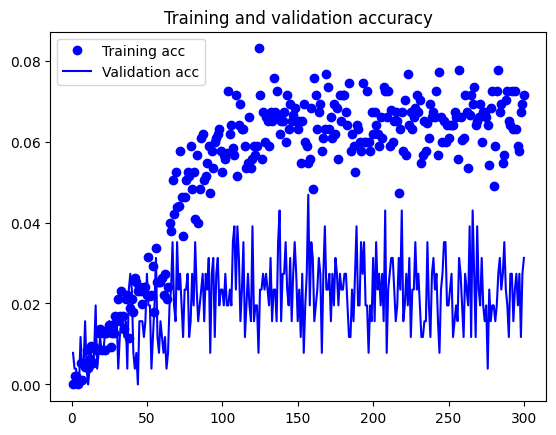

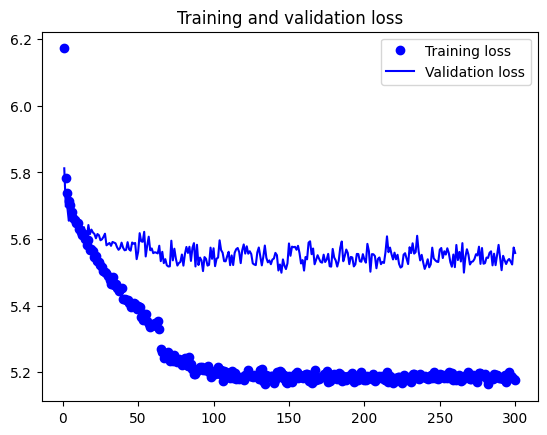

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_trained = range(1, len(acc) + 1)

plt.plot(epoch_trained, acc, 'bo', label='Training acc')
plt.plot(epoch_trained, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch_trained, loss, 'bo', label='Training loss')
plt.plot(epoch_trained, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
# Loading the automatically saved model
model_reloaded = load_model(model_path  + model_name + '.h5', custom_objects={'BatchNormalization': layers.BatchNormalization})

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)
best_model = load_model(model_name_temp)

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_1), but
are not present in its tracked objects:
  <tf.Variable 'conv1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/beta:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


IndexError: list index out of range

In [48]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe= test_df,x_col="File_Path",y_col="Label",target_size=(224,224), batch_size=batch_size)

test_loss, test_acc = best_model.evaluate(test_generator, steps=test_steps)
print()
print('Test Accuracy:', test_acc)

Found 284 validated image filenames belonging to 284 classes.


NameError: name 'best_model' is not defined

In [41]:
img_height = 224
img_width = 224
pk.dump(img_height, open(checkpoint_dir+ '\\' +'img_height.pkl', 'wb'))
pk.dump(img_width, open(checkpoint_dir+ '\\' +'img_width.pkl', 'wb'))
# current best stuff
df = pd.read_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')
df = df.sort_values(by=['Category'], ascending=True)
categories = df['Category'].tolist()  


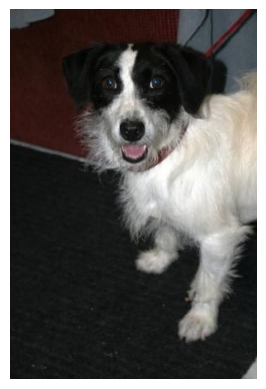


------------------------------------
Predicted Class:  22318796
Predicted Class:  22324248
Predicted Class:  23890646
Predicted Class:  30315817
Predicted Class:  31220026
Predicted Class:  31265745
Predicted Class:  32097140
Predicted Class:  32978087
Predicted Class:  34664593
Predicted Class:  34744029
Predicted Class:  34865158
Predicted Class:  36659999
Predicted Class:  37036429
Predicted Class:  37520057
Predicted Class:  37564105
Predicted Class:  37723352
Predicted Class:  37811426
Predicted Class:  37864159
Predicted Class:  38053837
------------------------------------


In [46]:
img_pred = cv2.imread('../photos/organized_photos/val/10014499/10014499-1.jpg')

plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
img_pred = cv2.resize(img_pred,(img_height,img_width))
img_pred = np.reshape(img_pred,[1,img_height,img_width,3])
classes = (best_model.predict(img_pred)).astype("int32")
# find index of 1 in classes
index = np.where(classes == 1)
index = index[1]


print()
print('------------------------------------')
for i in range(len(index)):
    print('Predicted Class: ' , categories[index[i]])
print('------------------------------------')